DIAGNOSTIC INFORMATION

Time array:
  Shape: (18300,)
  Min: 1354.112848080591
  Max: 1381.5187478500325
  Range: 27.405899769441476 days
  Number of finite values: 18300
  First 5 values: [1354.11284808 1354.11423702 1354.11562595 1354.11840382 1354.11979276]

Flux array:
  Shape: (18300,)
  Min: 10484.5234375
  Max: 10589.1884765625
  Mean: 10539.099609375
  Median: 10539.2958984375
  Std: 13.387608528137207
  Number of finite values:   ———
  First 5 values: [10514.14  10522.516 10536.679 10533.068 10533.499]

Flux range: 104.6650390625
 Flux appears to be in raw units (median: 10539.2958984375)

Best period found: 6.3139 days
Maximum power: 0.9640


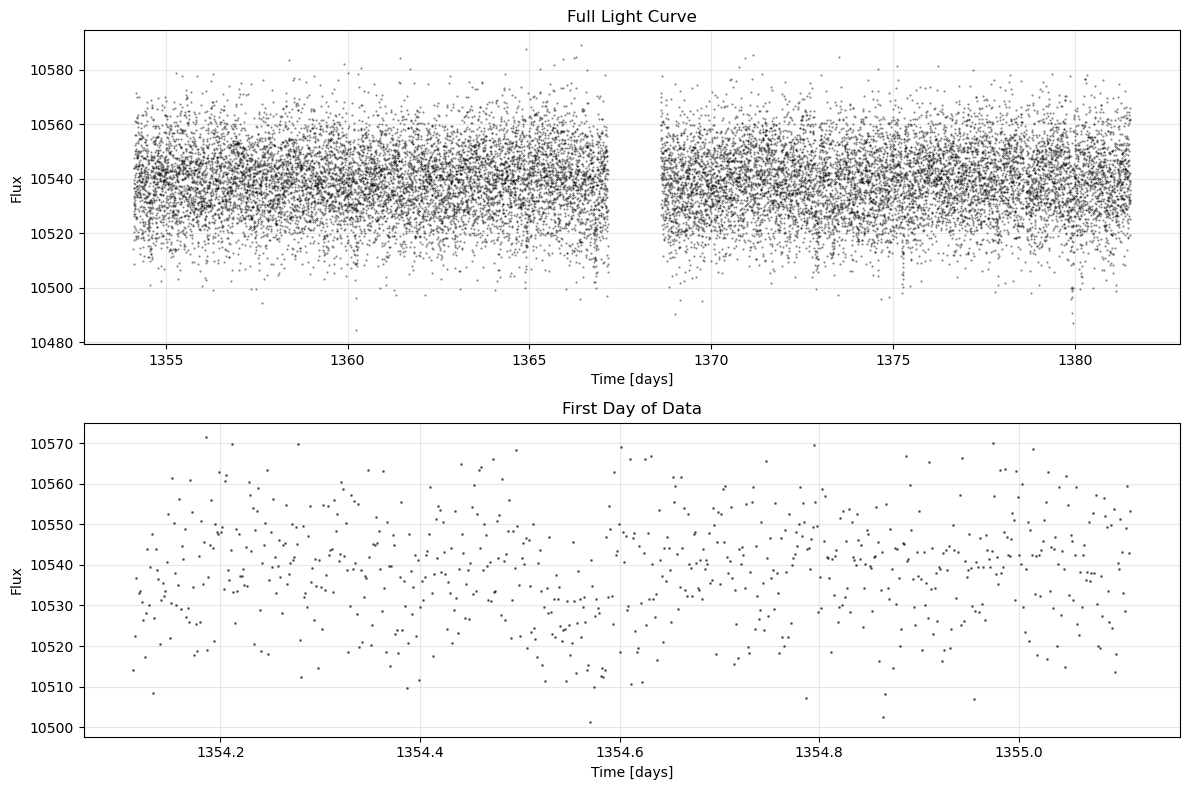

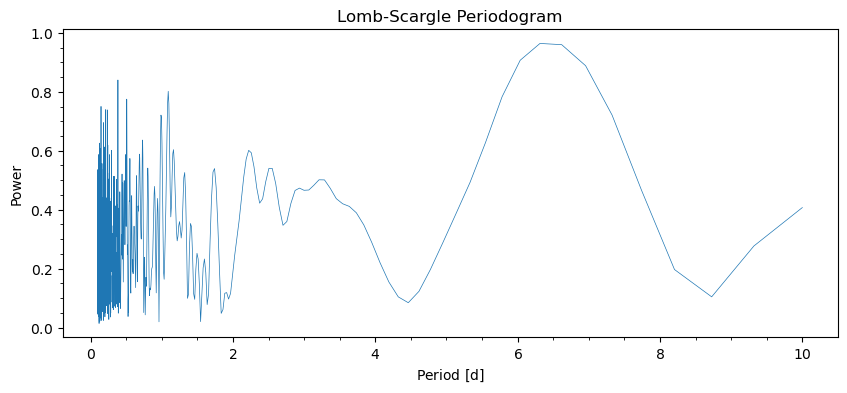

In [2]:
#Diagnosing
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

# Path to your FITS file
fits_file_path = "/Users/suyuxin/downloads/mastDownload/TESS/tess2018234235059-s0002-0000000251848941-0121-s/tess2018234235059-s0002-0000000251848941-0121-s_lc.fits"
# Read the light curve
lc = lk.read(fits_file_path)

# Extract time and flux
time = lc.time.value
flux = lc.flux.value


print("DIAGNOSTIC INFORMATION")


print(f"\nTime array:")
print(f"  Shape: {time.shape}")
print(f"  Min: {np.nanmin(time)}")
print(f"  Max: {np.nanmax(time)}")
print(f"  Range: {np.nanmax(time) - np.nanmin(time)} days")
print(f"  Number of finite values: {np.sum(np.isfinite(time))}")
print(f"  First 5 values: {time[:5]}")

print(f"\nFlux array:")
print(f"  Shape: {flux.shape}")
print(f"  Min: {np.nanmin(flux)}")
print(f"  Max: {np.nanmax(flux)}")
print(f"  Mean: {np.nanmean(flux)}")
print(f"  Median: {np.nanmedian(flux)}")
print(f"  Std: {np.nanstd(flux)}")
print(f"  Number of finite values: {np.sum(np.isfinite(flux))}")
print(f"  First 5 values: {flux[:5]}")


flux_range = np.nanmax(flux) - np.nanmin(flux)
print(f"\nFlux range: {flux_range}")
if np.nanmedian(flux) > 0.5 and np.nanmedian(flux) < 2:
    print(" Flux appears to be NORMALIZED (centered around 1)")
else:
    print(f" Flux appears to be in raw units (median: {np.nanmedian(flux)})")

# Create a simple diagnostic plot
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Plot 1: Full light curve
ax1 = axes[0]
ax1.plot(time, flux, 'k.', markersize=1, alpha=0.5)
ax1.set_xlabel('Time [days]')
ax1.set_ylabel('Flux')
ax1.set_title('Full Light Curve')
ax1.grid(True, alpha=0.3)

# Plot 2: Zoomed to first day
ax2 = axes[1]
mask = (time >= time[0]) & (time <= time[0] + 1)
ax2.plot(time[mask], flux[mask], 'k.', markersize=2, alpha=0.5)
ax2.set_xlabel('Time [days]')
ax2.set_ylabel('Flux')
ax2.set_title('First Day of Data')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('diagnostic_plot.png', dpi=150, bbox_inches='tight')
#print("\nDiagnostic plot saved as 'diagnostic_plot.png'")


try:
    # Remove NaNs
    mask = np.isfinite(time) & np.isfinite(flux)
    time_clean = time[mask]
    flux_clean = flux[mask]
    
    # Create a periodogram
    from lightkurve import LightCurve
    lc_obj = LightCurve(time=time_clean, flux=flux_clean)
    pg = lc_obj.to_periodogram(method='lombscargle', minimum_period=0.1, maximum_period=10)
    
    best_period = pg.period_at_max_power.value
    max_power = pg.max_power.value
    
    print(f"\nBest period found: {best_period:.4f} days")
    print(f"Maximum power: {max_power:.4f}")
    
    # Save periodogram
    fig, ax = plt.subplots(figsize=(10, 4))
    pg.plot(ax=ax)
    ax.set_title('Lomb-Scargle Periodogram')
    #plt.savefig('periodogram.png', dpi=150, bbox_inches='tight')
    plt.show()
    #print("Periodogram saved as 'periodogram.png'")
    
except Exception as e:
    print(f"\nCould not compute periodogram: {e}")


Data points: 18299
Time range: 1354.11 to 1381.52 days (27.41 days total)
Flux range: 10484.52 to 10589.19
Flux median: 10539.30
Flux std: 13.39
Amplitude: 0.127%
Y-axis limits: (MaskedNDArray(10472.35785103), MaskedNDArray(10606.23394585))
Time is Binned to 158 points
  Phase-binned to 50 points
  Phase-binned to 50 points


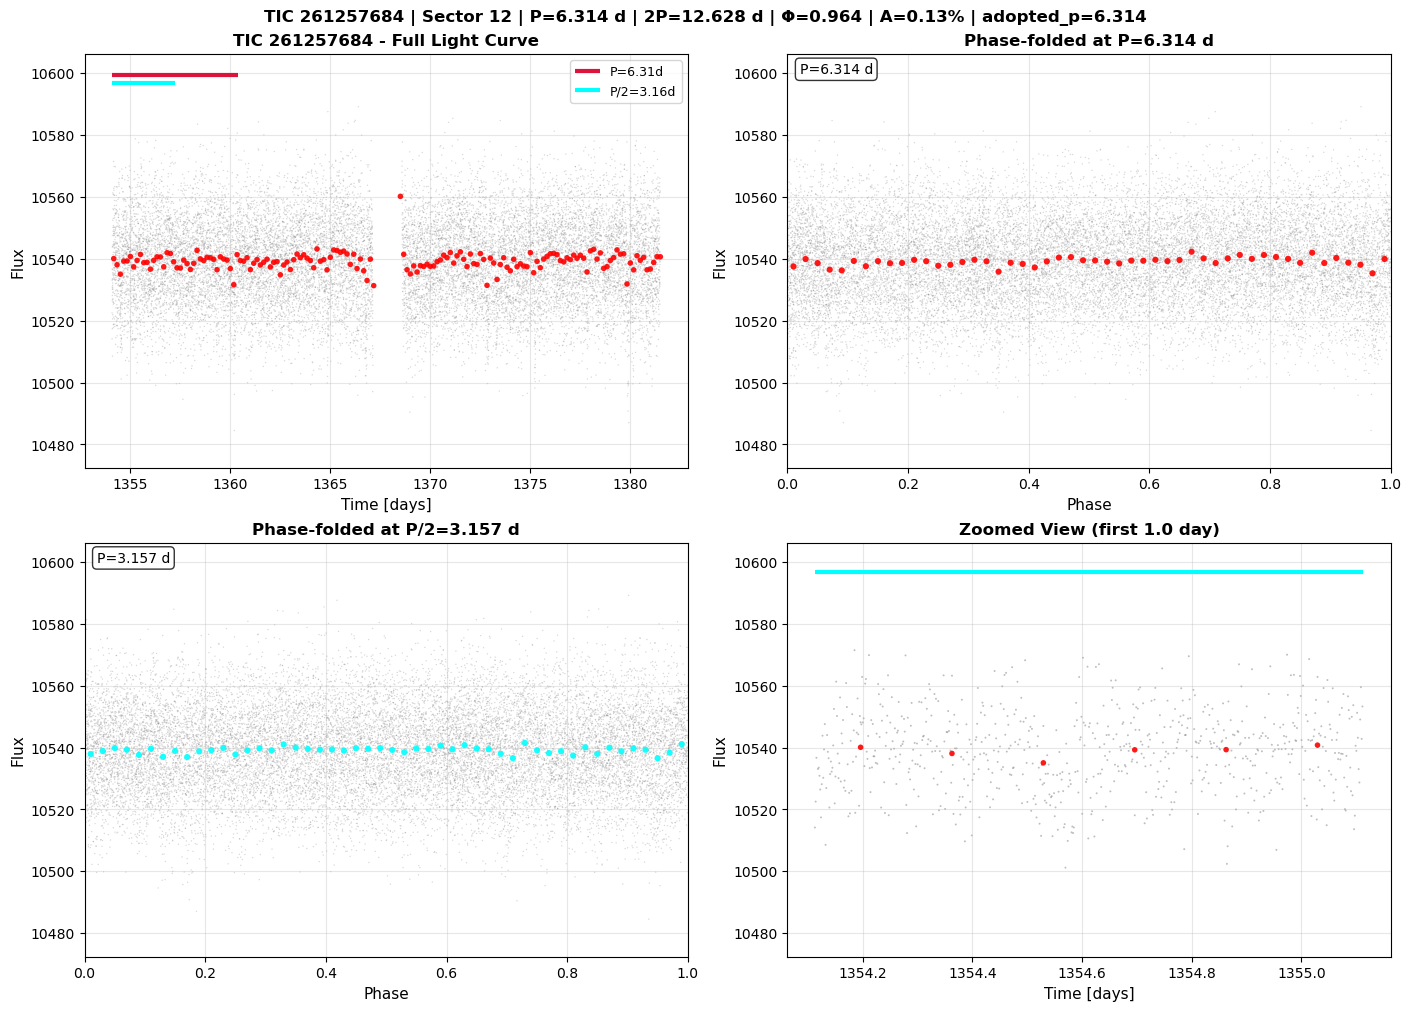

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk

def _bin_series_fixed_width(x, y, width):
    # Validate the bin width
    # If width is NaN, infinity, or negative, return empty arrays
    if not np.isfinite(width) or width <= 0:
        return np.array([]), np.array([])
    
    # Convert inputs to numpy arrays
    x_arr = np.asarray(x, dtype=float)
    y_arr = np.asarray(y, dtype=float)
    
    #Filter out invalid data (NaN, infinity) 
    mask = np.isfinite(x_arr) & np.isfinite(y_arr)
    if not mask.any():
        return np.array([]), np.array([])
    x_valid = x_arr[mask]
    y_valid = y_arr[mask]
    x_min = np.nanmin(x_valid)
    x_max = np.nanmax(x_valid)
    
    if not np.isfinite(x_min) or not np.isfinite(x_max):
        return np.array([]), np.array([])
    if x_min == x_max:
        # Normal case: create bins from x_min to x_max
        # Example: x_min=0, x_max=10, width=2
        # edges = [0, 2, 4, 6, 8, 10, 12]
        edges = np.array([x_min, x_min + width])
    else:
        edges = np.arange(x_min, x_max + width, width)
        # If somehow we got fewer than 2 edges, just use min and max
        if edges.size < 2:
            edges = np.array([x_min, x_max])
    return _bin_series_by_edges(x_valid, y_valid, edges)


def _bin_series_by_edges(x, y, edges):
    x_arr = np.asarray(x, dtype=float)
    y_arr = np.asarray(y, dtype=float)
    mask = np.isfinite(x_arr) & np.isfinite(y_arr)
    if not mask.any():
        return np.array([]), np.array([])
    x_valid = x_arr[mask]
    y_valid = y_arr[mask]
    inds = np.digitize(x_valid, edges) - 1
    # Example:
    # edges = [0, 2, 4, 6]
    # x = [1.5, 3.2, 5.1]
    # digitize gives: [1, 2, 3]
    # After -1: [0, 1, 2], these are bin indices
    valid = (inds >= 0) & (inds < len(edges) - 1)
    if not valid.any():
        return np.array([]), np.array([])
    x_valid = x_valid[valid]
    y_valid = y_valid[valid]
    inds = inds[valid]
    # Calculate the average (x, y) for each bin
    centers = []
    values = []
    for idx in np.unique(inds):
        bin_mask = inds == idx
        if np.any(bin_mask):
            centers.append(0.5 * (edges[idx] + edges[idx + 1]))
            values.append(np.nanmean(y_valid[bin_mask]))
    return np.array(centers), np.array(values)


def _get_flux_ylim(flux_vals):
    """Calculate y-axis limits based on flux statistics"""
    finite_flux = flux_vals[np.isfinite(flux_vals)]
    if finite_flux.size == 0:
        return None
    
    f_med = np.nanmedian(finite_flux)
    f_std = np.nanstd(finite_flux)
    
    if not np.isfinite(f_std) or f_std == 0:
        f_std = 0.01 * abs(f_med) if f_med != 0 else 1.0
    
    # Use 5-sigma range, almost the full data set
    return (f_med - 5 * f_std, f_med + 5 * f_std)



# Based on diagnostic output:
# - Flux median: 10539.3
# - Flux std: 13.4
# - Detected period: 6.3139 days
# - Power: 0.9640

# Path to your FITS file
fits_file_path = "/Users/suyuxin/downloads/mastDownload/TESS/tess2018234235059-s0002-0000000251848941-0121-s/tess2018234235059-s0002-0000000251848941-0121-s_lc.fits"

# Star parameters
ticid = 261257684
sector = 12
star_period = 6.3139  # From periodogram detection
star_power = 0.9640   # From periodogram
amp = 13.4 / 10539.3  # std / median ≈ 0.00127 or 0.127%
adopted_period = 6.3139


#output_figure = "light_curve_analysis.png"
output_figure = "/Users/suyuxin/Downloads/light_curve_analysis.png"


lc = lk.read(fits_file_path)
time = lc.time.value
flux = lc.flux.value

# Remove NaNs
mask = np.isfinite(time) & np.isfinite(flux)
time = time[mask]
flux = flux[mask]

print(f"Data points: {len(time)}")
print(f"Time range: {time.min():.2f} to {time.max():.2f} days ({time.max() - time.min():.2f} days total)")
print(f"Flux range: {flux.min():.2f} to {flux.max():.2f}")
print(f"Flux median: {np.median(flux):.2f}")
print(f"Flux std: {np.std(flux):.2f}")
print(f"Amplitude: {amp*100:.3f}%")

# Create figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10), constrained_layout=True)
ax_time = axes[0, 0]
ax_phase = axes[0, 1]
ax_two_phase = axes[1, 0]
ax_zoom = axes[1, 1]

# Calculate ylims once (based on actual flux values, not amp)
ylims = _get_flux_ylim(flux)
print(f"Y-axis limits: {ylims}")

# PLOT 1: Full time series

ax_time.scatter(time, flux, s=1, color="0.5", alpha=0.3, edgecolor="none")

bin_width_days = 4.0 / 24.0  # 4 hours
binned_time, binned_flux = _bin_series_fixed_width(time, flux, bin_width_days)
if binned_time.size > 0:
    ax_time.scatter(binned_time, binned_flux, s=16, color="red", alpha=0.9, 
                   edgecolor="none", zorder=5)
    print(f"Time is Binned to {len(binned_time)} points")

ax_time.set_xlabel("Time [days]", fontsize=11)
ax_time.set_ylabel("Flux", fontsize=11)
ax_time.set_title(f"TIC {ticid} - Full Light Curve", fontsize=12, fontweight='bold')
ax_time.grid(True, alpha=0.3)
if ylims:
    ax_time.set_ylim(ylims)

# Add period markers
if np.isfinite(star_period) and star_period > 0:
    y_pos = ylims[1] - 0.05 * (ylims[1] - ylims[0])
    x_start = time.min()
    x_end = x_start + star_period
    ax_time.hlines(y_pos, x_start, x_end, colors="crimson", linewidth=3, 
                  label=f'P={star_period:.2f}d', zorder=10)
    
    x_end_half = x_start + 0.5 * star_period
    ax_time.hlines(y_pos - 0.02*(ylims[1] - ylims[0]), x_start, x_end_half, 
                  colors="cyan", linewidth=3, label=f'P/2={star_period/2:.2f}d', zorder=10)
    ax_time.legend(loc='upper right', fontsize=9)

#PLOT 2: Phase-folded at full period 

if np.isfinite(star_period) and star_period > 0:
    time0 = time.min()
    phase = np.mod(time - time0, star_period) / star_period
    
    ax_phase.scatter(phase, flux, s=1, color="0.5", alpha=0.3, edgecolor="none")
    
    # Bin in phase
    phase_edges = np.linspace(0, 1, 51)  # 50 bins
    binned_phase, binned_phase_flux = _bin_series_by_edges(phase, flux, phase_edges)
    if binned_phase.size > 0:
        ax_phase.scatter(binned_phase, binned_phase_flux, s=20, color="red", 
                        alpha=0.9, edgecolor="none", zorder=5)
        print(f"  Phase-binned to {len(binned_phase)} points")
    
    ax_phase.set_xlim(0, 1)
    ax_phase.text(0.02, 0.98, f"P={star_period:.3f} d", 
                 transform=ax_phase.transAxes, ha="left", va="top", 
                 fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax_phase.text(0.5, 0.5, "No valid period", ha="center", va="center",
                 transform=ax_phase.transAxes, fontsize=12, color='red')

ax_phase.set_xlabel("Phase", fontsize=11)
ax_phase.set_ylabel("Flux", fontsize=11)
ax_phase.set_title(f"Phase-folded at P={star_period:.3f} d", fontsize=12, fontweight='bold')
ax_phase.grid(True, alpha=0.3)
if ylims:
    ax_phase.set_ylim(ylims)

# PLOT 3: Phase-folded at half period 

period_half = 0.5 * star_period
if np.isfinite(period_half) and period_half > 0:
    time0 = time.min()
    phase = np.mod(time - time0, period_half) / period_half
    
    ax_two_phase.scatter(phase, flux, s=1, color="0.5", alpha=0.3, edgecolor="none")
    
    # Bin in phase
    phase_edges = np.linspace(0, 1, 51)
    binned_phase, binned_phase_flux = _bin_series_by_edges(phase, flux, phase_edges)
    if binned_phase.size > 0:
        ax_two_phase.scatter(binned_phase, binned_phase_flux, s=20, color="cyan", 
                           alpha=0.9, edgecolor="none", zorder=5)
        print(f"  Phase-binned to {len(binned_phase)} points")
    
    ax_two_phase.set_xlim(0, 1)
    ax_two_phase.text(0.02, 0.98, f"P={period_half:.3f} d", 
                     transform=ax_two_phase.transAxes, ha="left", va="top",
                     fontsize=10, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
else:
    ax_two_phase.text(0.5, 0.5, "No valid period", ha="center", va="center",
                     transform=ax_two_phase.transAxes, fontsize=12, color='red')

ax_two_phase.set_xlabel("Phase", fontsize=11)
ax_two_phase.set_ylabel("Flux", fontsize=11)
ax_two_phase.set_title(f"Phase-folded at P/2={period_half:.3f} d", fontsize=12, fontweight='bold')
ax_two_phase.grid(True, alpha=0.3)
if ylims:
    ax_two_phase.set_ylim(ylims)

#PLOT 4: Zoomed time series
zoom_duration = 1.0  # Show 1 day
mask_zoom = (time >= time.min()) & (time <= time.min() + zoom_duration)

ax_zoom.scatter(time[mask_zoom], flux[mask_zoom], s=2, color="0.5", alpha=0.5, edgecolor="none")

binned_time_zoom, binned_flux_zoom = _bin_series_fixed_width(time[mask_zoom], flux[mask_zoom], bin_width_days)
if binned_time_zoom.size > 0:
    ax_zoom.scatter(binned_time_zoom, binned_flux_zoom, s=16, color="red", 
                   alpha=0.9, edgecolor="none", zorder=5)

ax_zoom.set_xlabel("Time [days]", fontsize=11)
ax_zoom.set_ylabel("Flux", fontsize=11)
ax_zoom.set_title(f"Zoomed View (first {zoom_duration:.1f} day)", fontsize=12, fontweight='bold')
ax_zoom.grid(True, alpha=0.3)
if ylims:
    ax_zoom.set_ylim(ylims)


if np.isfinite(star_period) and star_period > 0 and ylims:
    y_pos = ylims[1] - 0.05 * (ylims[1] - ylims[0])
    
    x_start = time.min()
    x_end = min(x_start + star_period, time.min() + zoom_duration)
    if x_end > x_start and star_period <= zoom_duration:
        ax_zoom.hlines(y_pos, x_start, x_end, colors="crimson", linewidth=3, zorder=10)
    
    # Half period marker
    x_end_half = min(x_start + 0.5 * star_period, time.min() + zoom_duration)
    if x_end_half > x_start:
        ax_zoom.hlines(y_pos - 0.02*(ylims[1] - ylims[0]), x_start, x_end_half, 
                      colors="cyan", linewidth=3, zorder=10)

# Overall title
fig.suptitle(
    f"TIC {ticid} | Sector {sector} | P={star_period:.3f} d | 2P={2*star_period:.3f} d | Φ={star_power:.3f} | A={amp*100:.2f}% | adopted_p={adopted_period:.3f}",
    fontsize=12, fontweight='bold'
)

# Save figure
plt.savefig(output_figure, dpi=300, bbox_inches='tight')
plt.show()
#print(f"Figure saved to: {output_figure}")

plt.close()